In [2]:
import os.path
import pandas as pd

busco_stats_path = "data/WBPS19_busco_stats.tsv"
outdir = "data/helixer_training_species/"

full_df = pd.read_csv(busco_stats_path, delimiter="\t")

# Take genus to be first part of species name
full_df["genus"] = full_df["genome"].str.split("_").apply(lambda x: x[0])

A number of species failed pre-processing by GeenuFF, so sould be removed from contention

In [3]:
with open(os.path.join(outdir, "failed_set.txt")) as f:
    fail_set = f.read().splitlines()
full_df = full_df[~full_df["genome"].isin(fail_set)]

Determinine candidates for rerunning Helixer/BRAKER on once a good model has been trained. These have the biggest difference in quality of assembly (generally good) vs quality of existing annotation (generally poor). If we were to take a species with a poor annotation but an equally poor assembly, we would understandably not gain much improved BUSCO scores regardless of the annotation tool we choose.

In [4]:
full_df["C_diff"] = full_df["C_as"] - full_df["C_an"]
reann_set = full_df.sort_values("C_diff", ascending=False).head(5)
reann_set["genome"].to_csv(os.path.join(outdir, "reannotation_set.txt"), sep="\n", index=False, header=False)
reann_set[["genome", "C_as", "C_an", "C_diff"]]

,genome,C_as,C_an,C_diff
106,heterorhabditis_bacteriophora_prjna13977,87.1,31.4,55.7
231,teladorsagia_circumcincta_prjna72569,71.8,38.4,33.4
5,ancylostoma_ceylanicum_prjna72583,87.2,58.9,28.3
86,globodera_pallida_prjna702104,59.5,38.6,20.9
8,angiostrongylus_cantonensis_prjna350391,83.6,67.4,16.2


For the training set and validation sets, we should ensure a minimum BUSCO Completeness of **60** (as a broad threshold), and that the species isn't already earmarked for reannotation.

In [5]:
df = full_df[(full_df["C_an"] >= 60) & (~full_df["genome"].isin(reann_set["genome"]))]

For training set, we'll pick one from each genus, prioritising the one with the highest annotation BUSCO Completeness

In [6]:
train_set = df.sort_values("C_an", ascending=False).drop_duplicates("genus")
train_set["genome"].sort_values().to_csv(os.path.join(outdir, "training_set.txt"), sep="\n", index=False, header=False)
train_set.head(5)

,genome,C_an,D_an,F_an,M_an,N_an,C_as,D_as,F_as,M_as,N_as,genus,C_diff
34,caenorhabditis_briggsae_qx1410prjna784955,98.5,0.6,0.9,0.6,982,98.5,0.6,0.7,0.8,982,caenorhabditis,0.0
264,wuchereria_bancrofti_prjna275548,98.2,2.3,0.9,0.9,982,97.5,1.9,1.7,0.8,982,wuchereria,-0.7
117,loa_loa_prjna37757,96.3,0.7,3.7,0.0,982,96.0,0.7,3.7,0.3,982,loa,-0.3
52,cercopithifilaria_johnstoni_prjeb47283,95.9,0.7,2.3,1.8,982,94.4,0.8,4.2,1.4,982,cercopithifilaria,-1.5
62,diploscapter_coronatus_prjdb3143,94.4,88.9,3.6,2.0,982,91.5,67.9,4.6,3.9,982,diploscapter,-2.9


For validation set, we'll pick the second best species from each criteria, based on previous criteria.

In [6]:
valid_set = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set["genome"])].drop_duplicates("genus")
valid_set["genome"].sort_values().to_csv(os.path.join(outdir, "validation_set.txt"), sep="\n", index=False, header=False)
valid_set.head(5)

/tmp/ipykernel_9827/1398248434.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_set = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set["genome"])].drop_duplicates("genus")


,genome,C_an,D_an,F_an,M_an,N_an,C_as,D_as,F_as,M_as,N_as,genus,C_diff
51,caenorhabditis_zanzibari_prjeb12596,98.5,1.9,1.0,0.5,982,98.2,1.3,1.2,0.6,982,caenorhabditis,-0.3
116,loa_loa_prjna246086,94.7,1.3,3.5,1.8,982,97.5,1.3,2.0,0.5,982,loa,2.8
176,pristionchus_maxplancki_prjeb27334,93.5,13.4,4.2,2.3,982,90.6,9.4,5.5,3.9,982,pristionchus,-2.9
151,oscheius_tipulae_prjeb15512,89.8,3.4,5.7,4.5,982,89.4,3.0,3.2,7.4,982,oscheius,-0.4
249,trichinella_spiralis_prjna257433,88.9,3.0,5.7,5.4,982,89.7,2.3,7.1,3.2,982,trichinella,0.8


In [7]:
print("Total species:\t\t\t{}".format(len(full_df)))
print("Species in...")
print("\treannotation set:\t{}".format(len(reann_set)))
print("\ttraining set:\t\t{}".format(len(train_set)))
print("\tvalidation set:\t\t{}".format(len(valid_set)))

Total species:			263
Species in...
	reannotation set:	5
	training set:		84
	validation set:		40


### Top 40 Training Set

In [15]:
train_set_40 = train_set.head(40)
train_set_40["genome"].sort_values().to_csv(os.path.join(outdir, "training_set_top40.txt"), sep="\n", index=False, header=False)

We'll rebuild the validation set now that more species will be available after being filtered from the training set

In [16]:
valid_set_40 = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set_40["genome"])].drop_duplicates("genus")
valid_set_40["genome"].sort_values().to_csv(os.path.join(outdir, "validation_set_top40.txt"), sep="\n", index=False, header=False)

/tmp/ipykernel_9827/3457853504.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_set_40 = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set_40["genome"])].drop_duplicates("genus")


In [17]:
print("Species in...")
print("\ttraining set:\t\t{}".format(len(train_set_40)))
print("\tvalidation set:\t\t{}".format(len(valid_set_40)))

Species in...
	training set:		40
	validation set:		67


### Mixed quality training and validation

<Axes: ylabel='Frequency'>

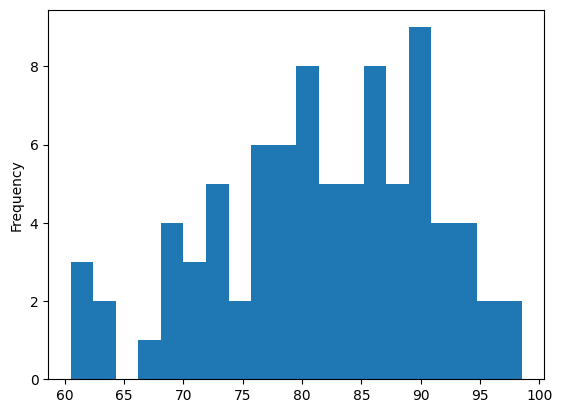

In [22]:
df.sort_values("C_an", ascending=False).drop_duplicates("genus")["C_an"].plot(kind="hist", bins=20)

In [41]:
df_pool = df.sort_values("C_an", ascending=False).drop_duplicates("genus")
sample_size = round(len(df_pool) / 2)
train_set_mix = df_pool.sample(sample_size)
valid_set_mix = df_pool[~df_pool["genome"].isin(train_set_mix["genome"])]

<Axes: ylabel='Frequency'>

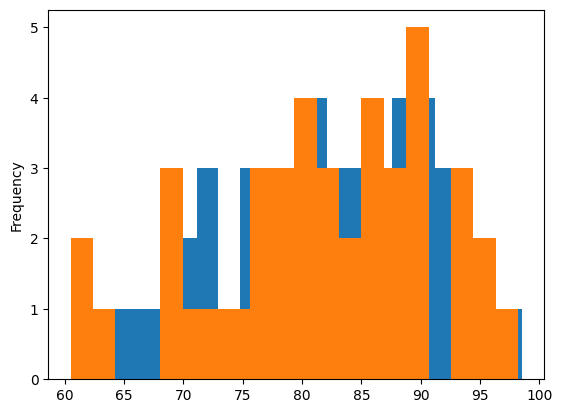

In [42]:
valid_set_mix["C_an"].plot(kind="hist", bins=20)
train_set_mix["C_an"].plot(kind="hist", bins=20)

In [43]:
train_set_mix["genome"].sort_values().to_csv(os.path.join(outdir, "training_set_mixed.txt"), sep="\n", index=False, header=False)
valid_set_mix["genome"].sort_values().to_csv(os.path.join(outdir, "validation_set_mixed.txt"), sep="\n", index=False, header=False)

In [44]:
print("Species in...")
print("\ttraining set:\t\t{}".format(len(train_set_mix)))
print("\tvalidation set:\t\t{}".format(len(valid_set_mix)))

Species in...
	training set:		42
	validation set:		42


### High Quality Training Set

Let us filter  the training set so that BUSCO Annotation Completeness is >= 75

In [10]:
train_set_hq = train_set[train_set["C_an"] >= 75]
train_set_hq["genome"].sort_values().to_csv(os.path.join(outdir, "training_set_hq.txt"), sep="\n", index=False, header=False)

66

We'll rebuild the validation set now that more species will be available after being filtered from the training set

In [11]:
valid_set_hq = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set_hq["genome"])].drop_duplicates("genus")
valid_set_hq["genome"].sort_values().to_csv(os.path.join(outdir, "validation_set_hq.txt"), sep="\n", index=False, header=False)

/tmp/ipykernel_95164/452821630.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_set_hq = df.sort_values("C_an", ascending=False)[~df["genome"].isin(train_set_hq["genome"])].drop_duplicates("genus")


In [12]:
print("Species in...")
print("\ttraining set:\t\t{}".format(len(train_set_hq)))
print("\tvalidation set:\t\t{}".format(len(valid_set_hq)))

Species in...
	training set:		66
	validation set:		55
